**Митрофанов А.А**
# Анализ тональности текста 
Анализ тональности текста направлен на автоматическое определение эмоциональной лексики и эмоциональной оценки авторов по отношению к объектам, речь о которых идёт в тексте. 
Тональность — это эмоциональное отношение автора высказывания к некоторому объекту выраженное в тексте.

В данной работе рассматривается анализ тональности текста из корпуса RuSentiment.
Данный корпус состоит из ~30 тысяч текстовых комментариев и меток тональности к каждому коментарию. 
Возможно пять меток 'skip', 'speech', 'negative', 'neutral' и 'positive'. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import torch
import sklearn

from razdel import tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.metrics import classification_report, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC

from transformers import AutoTokenizer, AutoModel
from razdel import tokenize
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# 1. Данные

In [2]:
#ID2LABEL = ['skip', 'speech', 'negative', 'neutral', 'positive']
#LABEL2ID = {l: i for i,l in enumerate(ID2LABEL)}
ID2LABEL = ['negative', 'neutral', 'positive']
LABEL2ID = {l: i for i,l in enumerate(ID2LABEL)}

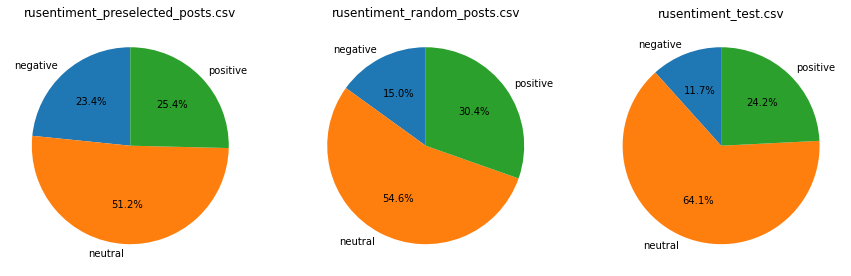

Распределение ко классам для каждого из файлов, входящих в базу RuSentiment


In [11]:
def load_data(file, ax=plt, drop_labels=('skip', 'speech')):
    # Загрузка данных и отрисовка распределения классов
    data = pd.read_csv(file)
    data['label'] = data.apply(lambda row: row['label'] if row['label'] not in drop_labels else np.NaN, axis=1)
    data.dropna(inplace=True)
    ax.set_title(os.path.basename(file))
    ax.pie(data.groupby('label').count().values.reshape(-1), labels=ID2LABEL, autopct='%1.1f%%',
            shadow=False, startangle=90)
    return data
#plt.figure(figsize=(10,10))
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 6))
rs_preselected = load_data('data/rusentiment/Dataset/rusentiment_preselected_posts.csv', ax1)
rs_random = load_data('data/rusentiment/Dataset/rusentiment_random_posts.csv', ax2)
rs_test = load_data('data/rusentiment/Dataset/rusentiment_test.csv', ax3)
plt.show()
print("Распределение ко классам для каждого из файлов, входящих в базу RuSentiment")

In [12]:
print(f'Распределение по классам в трейне {rs_random.groupby("label").count()}')

Распределение по классам в трейне           text
label         
negative  2294
neutral   8323
positive  4635


In [13]:
print(f'Total number of sentences for rusentiment_preselected_posts is {len(rs_preselected)}')
print(f'Total number of sentences for rusentiment_random_posts is {len(rs_random)}')
print(f'Total number of sentences for rusentiment_test is {len(rs_test)}')

Total number of sentences for rusentiment_preselected_posts is 5812
Total number of sentences for rusentiment_random_posts is 15252
Total number of sentences for rusentiment_test is 2214


In [14]:
for ds in [rs_preselected, rs_random, rs_test]: 
    ds['label_id'] = ds.apply(lambda row: LABEL2ID[row['label']], axis=1)

In [15]:
# как выглядят данные
rs_preselected

,label,text,label_id
0,neutral,Прорвём информационную блокаду изнутри.,1
1,negative,"Никогда у меня не будет ""одного приложения для...",0
3,neutral,"Есть 3 типа людей:\nУмные, которые делают все ...",1
4,neutral,мегафон чет накрыло,1
7,neutral,Шах и мат.,1
...,...,...,...
6945,positive,"мы знаем , что мы лучшие(с):))",2
6946,neutral,Раз такая ежовая тема☺️😊❤️,1
6947,neutral,так вот оно что...),1
6948,positive,Бляяя...)) Вот это был номер...))) Такого я от...,2


# 2. Обучение моделей
Для обучения будем использовать сабсет данных rusentiment_random_posts, так как он больше чем rusentiment_preselected_posts. 

Для тестирования качества модели будем использовать rusentiment_test

Метрикой качества будет Unweighted Average Recall (UAR)

## 2.1 TF-IDF модели

Прежде чем применять TF-IDF преобразование можно сначала токенизировать датасет с помощью более продвинутого токенизатора ([razdel](https://github.com/natasha/razdel))

In [16]:
for ds in [rs_preselected, rs_random, rs_test]: 
    ds['tokenized'] = ds.apply(lambda row: [t.text for t in tokenize(row['text'])], axis=1)

In [17]:
# Обучаем tf-idf и 
tfidf = TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, max_features=1000)

train_tfidf = tfidf.fit_transform(rs_random['tokenized'])
test_tfidf = tfidf.transform(rs_test['tokenized'])

Для таких фич как tf-idf хорошо подходит наивный баевский классификатор.

Попробуем два NB классификатора:
* MultinomialNB
* ComplementNB

Помимо NB так же стоит попробовать Метод опорных векторов (SVC) и CatBoost. 

### MultinomialNB

In [18]:
nb_tfidf = MultinomialNB() 
nb_tfidf.fit(train_tfidf, rs_random['label_id'])

y = nb_tfidf.predict(test_tfidf)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

    negative       0.73      0.12      0.21       258
     neutral       0.73      0.89      0.80      1420
    positive       0.60      0.51      0.55       536

    accuracy                           0.71      2214
   macro avg       0.69      0.51      0.52      2214
weighted avg       0.70      0.71      0.67      2214

UAR = 0.5055683206415788


### ComplementNB

In [19]:
nb_tfidf = ComplementNB() # KNeighborsClassifier(n_neighbors=2)
nb_tfidf.fit(train_tfidf, rs_random['label_id'])

y = nb_tfidf.predict(test_tfidf)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

    negative       0.31      0.57      0.40       258
     neutral       0.84      0.55      0.66      1420
    positive       0.48      0.73      0.58       536

    accuracy                           0.59      2214
   macro avg       0.54      0.62      0.55      2214
weighted avg       0.69      0.59      0.61      2214

UAR = 0.6170027822455579


-----
### Support Vector Classification.

In [20]:
svc_tfidf = SVC() # KNeighborsClassifier(n_neighbors=2)
svc_tfidf.fit(train_tfidf, rs_random['label_id'])

y = svc_tfidf.predict(test_tfidf)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

    negative       0.61      0.26      0.37       258
     neutral       0.77      0.82      0.80      1420
    positive       0.57      0.62      0.60       536

    accuracy                           0.71      2214
   macro avg       0.65      0.57      0.59      2214
weighted avg       0.70      0.71      0.70      2214

UAR = 0.56982747850441


### CatBoost

In [21]:
cb_tfidf = CatBoostClassifier(iterations=8000, verbose=100)

cb_tfidf.fit(train_tfidf, rs_random['label_id'])

y = cb_tfidf.predict(test_tfidf)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

Learning rate set to 0.015688
0:	learn: 1.0932906	total: 91.6ms	remaining: 12m 12s
100:	learn: 0.8998015	total: 4.62s	remaining: 6m 1s
200:	learn: 0.8595005	total: 9.13s	remaining: 5m 54s
300:	learn: 0.8390682	total: 13.6s	remaining: 5m 48s
400:	learn: 0.8237410	total: 18.1s	remaining: 5m 43s
500:	learn: 0.8110826	total: 22.6s	remaining: 5m 38s
600:	learn: 0.8007934	total: 27.1s	remaining: 5m 33s
700:	learn: 0.7911952	total: 31.5s	remaining: 5m 28s
800:	learn: 0.7818424	total: 36s	remaining: 5m 23s
900:	learn: 0.7738690	total: 40.5s	remaining: 5m 18s
1000:	learn: 0.7667371	total: 44.9s	remaining: 5m 14s
1100:	learn: 0.7601397	total: 49.4s	remaining: 5m 9s
1200:	learn: 0.7542488	total: 53.8s	remaining: 5m 4s
1300:	learn: 0.7490491	total: 58.3s	remaining: 5m
1400:	learn: 0.7442797	total: 1m 2s	remaining: 4m 55s
1500:	learn: 0.7396884	total: 1m 7s	remaining: 4m 51s
1600:	learn: 0.7354747	total: 1m 11s	remaining: 4m 46s
1700:	learn: 0.7315640	total: 1m 16s	remaining: 4m 41s
1800:	learn: 0.

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()## BERT embeddings
Современной альтернативой для TF-IDF является использование предобученного экстрактора эмбеддингов BERT. 

In [22]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [23]:
BERT_TOKENIZER = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
BERT = AutoModel.from_pretrained("cointegrated/rubert-tiny")
BERT.cuda()  



print(embed_bert_cls('привет мир', BERT, BERT_TOKENIZER).shape)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(312,)


In [24]:
for ds in [rs_preselected, rs_random, rs_test]: 
    ds['bert_tiny'] = ds.apply(lambda row: embed_bert_cls(row['text'], BERT, BERT_TOKENIZER), axis=1)

In [25]:
train_bert = np.stack(rs_random['bert_tiny'].values)
test_bert = np.stack(rs_test['bert_tiny'].values)

Поскольку BERT признаки являются векторами, попробуем немного другие методы
* LogisticRegression
* GaussianNB
* SVC
* CatBoost

### Логистическая регрессия

In [26]:
lr_bert = LogisticRegression(max_iter=1000)
lr_bert.fit(train_bert, rs_random['label_id'])
y = lr_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

           0       0.48      0.38      0.43       258
           1       0.81      0.79      0.80      1420
           2       0.58      0.68      0.63       536

    accuracy                           0.71      2214
   macro avg       0.62      0.62      0.62      2214
weighted avg       0.72      0.71      0.71      2214

UAR = 0.616902983716639


### GaussianNB

In [27]:
nb_bert = GaussianNB()
nb_bert.fit(train_bert, rs_random['label_id'])
y = nb_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

           0       0.22      0.63      0.33       258
           1       0.83      0.42      0.56      1420
           2       0.44      0.60      0.51       536

    accuracy                           0.49      2214
   macro avg       0.49      0.55      0.46      2214
weighted avg       0.66      0.49      0.52      2214

UAR = 0.5530142577862951


### Support Vector Classification

In [28]:
svc_bert = SVC() 
svc_bert.fit(train_bert, rs_random['label_id'])

y = svc_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

              precision    recall  f1-score   support

    negative       0.54      0.38      0.45       258
     neutral       0.81      0.81      0.81      1420
    positive       0.61      0.68      0.64       536

    accuracy                           0.73      2214
   macro avg       0.65      0.63      0.63      2214
weighted avg       0.73      0.73      0.73      2214

UAR = 0.627115161174149


### CatBoostClassifier

In [29]:
cb_bert = CatBoostClassifier(iterations=11000, depth=8, verbose=100)
                          # learning_rate=0.05,
                          # depth=6,  #l2_leaf_reg=0.2)
cb_bert.fit(train_bert, rs_random['label_id'])
y = cb_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

Learning rate set to 0.011987
0:	learn: 1.0934167	total: 190ms	remaining: 34m 46s
100:	learn: 0.8463047	total: 21.3s	remaining: 38m 21s
200:	learn: 0.7621228	total: 42.2s	remaining: 37m 45s
300:	learn: 0.7129866	total: 1m 2s	remaining: 37m 2s
400:	learn: 0.6768934	total: 1m 22s	remaining: 36m 18s
500:	learn: 0.6479548	total: 1m 41s	remaining: 35m 35s
600:	learn: 0.6241699	total: 2m	remaining: 34m 53s
700:	learn: 0.6025190	total: 2m 20s	remaining: 34m 18s
800:	learn: 0.5820659	total: 2m 39s	remaining: 33m 46s
900:	learn: 0.5637650	total: 2m 57s	remaining: 33m 12s
1000:	learn: 0.5460671	total: 3m 16s	remaining: 32m 40s
1100:	learn: 0.5296116	total: 3m 34s	remaining: 32m 9s
1200:	learn: 0.5144322	total: 3m 52s	remaining: 31m 38s
1300:	learn: 0.5002131	total: 4m 10s	remaining: 31m 10s
1400:	learn: 0.4869673	total: 4m 28s	remaining: 30m 42s
1500:	learn: 0.4738371	total: 4m 47s	remaining: 30m 16s
1600:	learn: 0.4615952	total: 5m 5s	remaining: 29m 51s
1700:	learn: 0.4502112	total: 5m 23s	rema

## BERT-base

In [30]:
BERT_TOKENIZER = AutoTokenizer.from_pretrained("ID2LABELov/rubert-base-cased")
BERT = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
BERT.cuda()


print(embed_bert_cls('привет мир', BERT, BERT_TOKENIZER).shape)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum lengt

(768,)


In [31]:
for ds in [rs_preselected, rs_random, rs_test]: 
    ds['bert_base'] = ds.apply(lambda row: embed_bert_cls(row['text'], BERT, BERT_TOKENIZER), axis=1)

KeyboardInterrupt: 

In [ ]:
train_bert = np.stack(rs_random['bert_base'].values)
test_bert = np.stack(rs_test['bert_base'].values)

### Логистическая регрессия

In [ ]:
lr_bert = LogisticRegression(max_iter=1000)
lr_bert.fit(train_bert, rs_random['label_id'])
y = lr_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

### Support Vector Classification

In [ ]:
svc_bert = SVC() 
svc_bert.fit(train_bert, rs_random['label_id'])

y = svc_bert.predict(test_bert)
print(classification_report(rs_test['label_id'], y, target_names=ID2LABEL))
print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

### CatBoost Classifier

In [ ]:
# tooo slow. 2h 
# cb_bert = CatBoostClassifier(iterations=8000, depth=8, verbose=100)
#                           # learning_rate=0.05,
#                           # depth=6,  #l2_leaf_reg=0.2)
# cb_bert.fit(train_bert, rs_random['label_id'])
# y = cb_bert.predict(test_bert)
# print(classification_report(rs_test['label_id'], y))
# print(f"UAR = {recall_score(rs_test['label_id'], y, average='macro')}")

# Нейросети

In [32]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import pytorch_lightning as pl
import torchmetrics

In [45]:
cls_weights = [0]*len(ID2LABEL) 
for k,v in rs_random.groupby("label").count().iterrows():
    #print(k,v)
    cls_weights[LABEL2ID[k]] = v['text']
cls_weights = torch.Tensor(cls_weights)
cls_weights /=sum(cls_weights)
cls_weights

tensor([0.1504, 0.5457, 0.3039])

In [46]:

class LitBase(pl.LightningModule):
  #Шаблон для моделей
    def __init__(self, lr=1e-4, wd=1e-6, 
                 scheduler=torch.optim.lr_scheduler.ExponentialLR, 
                 scheduler_kwargs={'gamma': 0.95}):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.model = None
        self.criterion = nn.CrossEntropyLoss(cls_weights.cuda())
        self.scheduler = scheduler
        self.scheduler_kwargs = scheduler_kwargs
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            if isinstance(x, list) and len(x) == 2 :
                x = x[0]
            else:
                print(f'{len(x)} {x[0].shape} {x[1].shape}')
                raise RuntimeError()
        return self.model(x)
    
    def compute_loss(self, batch, batch_idx):
        #print(batch)
        x, y = batch
        #print(f'{x.shape=} {y.shape=}')
        btz = x.shape[0]
        logits = self(x)
        #print(f'{logits.shape=}')
        loss = self.criterion(logits.view(btz, -1), y.long())
        return loss, logits
    
    def training_step(self, batch, batch_idx):
        # Logging to TensorBoard by default
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("val_loss", loss,  prog_bar=True)
        predicted = logits.argmax(dim=-1).view(-1)
        y = batch[1].view(-1)
        acc = (y == predicted).sum()/y.shape[0]
        self.log("val_acc", acc,  prog_bar=True)
        return loss
    
    def predicts_step(self, batch, batch_idx):
        x = batch[0]
        return self(x)

    def get_params(self):
        return {'weight_decay': self.wd,
              'learning_rate': self.lr, 
              'lr_scheduler': self.scheduler, 
              'lr_scheduler_kwargs': self.scheduler_kwargs}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        lr_scheduler = lr_scheduler_config = {           
            "scheduler": self.scheduler(optimizer, **self.scheduler_kwargs),
            "interval": "epoch"}
        return {'optimizer': optimizer,
                'lr_scheduler': lr_scheduler}


In [47]:
class LitDNN(LitBase):
    def __init__(self, 
                 num_features, 
                 num_layers=2, 
                 dim=512, 
                 num_labels=5,
                 dropout_p=0,  
                 batchnorm=False,
                 init_func=lambda x: x,
                 **kwargs):
        super().__init__(**kwargs)
        self.num_features = num_features
        self.num_layers = num_layers
        self.dim = dim
        self.dropout_p = dropout_p
        model = []
        for i in range(num_layers): 
            model.append(nn.Linear(num_features if i == 0 else dim, 
                                   num_labels if i == num_layers - 1 else dim))
            if i < num_layers - 1:
                if batchnorm:
                    model.append(torch.nn.BatchNorm1d(dim))
                model.append(nn.ReLU())
                if dropout_p>0:
                    model.append(nn.Dropout(dropout_p))
        self.model = nn.Sequential(*model)

        for params in self.model.parameters():
            if len(params.shape) > 1:
                init_func(params.data)
      
    def get_params(self):
        out = super().get_params()
        out['num_features'] = self.num_features
        out['num_layers'] = self.num_layers
        out['dim'] = self.dim
        out['dropout_p'] = self.dropout_p
        return out
  


In [48]:
train_torch_ds = TensorDataset(torch.from_numpy(train_tfidf.toarray()).float(), 
                               torch.from_numpy(rs_random['label_id'].values).float())

test_torch_ds = TensorDataset(torch.from_numpy(test_tfidf.toarray()).float(), 
                               torch.from_numpy(rs_test['label_id'].values).float())

In [49]:
def cls_report(model, dl):
    predict = []
    labels = []
    with torch.no_grad():
        for x, y in dl:
            logits = model(x)
            p = logits.argmax(dim=-1).cpu()
            predict.append(p.numpy())
            labels.append(y.numpy())
    predict = np.concatenate(predict)
    labels = np.concatenate(labels)

    report = sklearn.metrics.classification_report(labels, 
                                                predict, 
                                                target_names=ID2LABEL)
    cf = sklearn.metrics.confusion_matrix(labels, predict)
    return report, cf

In [53]:
EXPS = []
def print_exp(exp):
      for k,v in exp.items():
        print(f'{k}: {v}')

def RUN_EXP(model, batch_size=128, epochs=10):
    train_dl = DataLoader(train_torch_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    test_dl = DataLoader(test_torch_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    exp = model.get_params()
    exp['batch_size'] = batch_size
    exp['epochs'] = epochs
    print(f"Params {pd.Series(exp)}")
    trainer = pl.Trainer(gpus=1, 
                     auto_lr_find=False, 
                     max_epochs=epochs, 
                     log_every_n_steps=80, 
                     default_root_dir="models/dnn")

    trainer.fit(model, train_dl, test_dl)
    report = trainer.validate(model, test_dl)
    for k,v in report[0].items():
        exp[k] = v
    exp['val_report'], exp['val_cm'] = cls_report(model, test_dl)
    print_exp(exp)
    EXPS.append(exp)


In [54]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [55]:
dnn = LitDNN(1000, num_layers=4, num_labels=len(ID2LABEL), scheduler_kwargs={'gamma':1}, dropout_p=0.3, wd=1e-6)
RUN_EXP(dnn, epochs=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | Sequential       | 1.0 M 
-----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.157     Total estimated model params size (MB)


Params weight_decay                                                   0.000001
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                        {'gamma': 1}
num_features                                                       1000
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.3
batch_size                                                          128
epochs                                                               20
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.6996386647224426, 'val_loss': 0.6543294191360474}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 1}
num_features: 1000
num_layers: 4
dim: 512
dropout_p: 0.3
batch_size: 128
epochs: 20
val_loss: 0.6543294191360474
val_acc: 0.6996386647224426
val_report:               precision    recall  f1-score   support

    negative       0.49      0.31      0.38       258
     neutral       0.75      0.83      0.79      1420
    positive       0.55      0.49      0.52       536

    accuracy                           0.69      2214
   macro avg       0.60      0.54      0.56      2214
weighted avg       0.67      0.69      0.67      2214

val_cm: [[  80  144   34]
 [  60 1182  178]
 [  22  254  260]]


In [56]:
#gamma 0.95 | 0.48 0.61
#gamma 1 | 0.53 0.61
#LitDNN(1000, num_layers=4, scheduler_kwargs={'gamma':0.95}, dropout_p=0.3, wd=1e-4) | 0.49 0.62
#LitDNN(1000, num_layers=4, scheduler_kwargs={'gamma':1}, dropout_p=0.3, wd=1e-6) | 0.51 0.62

In [57]:
train_torch_ds = TensorDataset(torch.from_numpy(train_bert).float(), 
                               torch.from_numpy(rs_random['label_id'].values).float())

test_torch_ds = TensorDataset(torch.from_numpy(test_bert).float(), 
                               torch.from_numpy(rs_test['label_id'].values).float())

In [59]:
dnn = LitDNN(312, num_layers=4, num_labels=len(ID2LABEL), scheduler_kwargs={'gamma':0.95}, lr=1e-3, dropout_p=0.1, wd=1e-6)
RUN_EXP(dnn, epochs=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | Sequential       | 687 K 
-----------------------------------------------
687 K     Trainable params
0         Non-trainable params
687 K     Total params
2.748     Total estimated model params size (MB)


Params weight_decay                                                   0.000001
learning_rate                                                     0.001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        312
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.1
batch_size                                                          128
epochs                                                               20
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.6991869807243347, 'val_loss': 0.8228429555892944}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 312
num_layers: 4
dim: 512
dropout_p: 0.1
batch_size: 128
epochs: 20
val_loss: 0.8228429555892944
val_acc: 0.6991869807243347
val_report:               precision    recall  f1-score   support

    negative       0.44      0.40      0.42       258
     neutral       0.78      0.78      0.78      1420
    positive       0.57      0.61      0.59       536

    accuracy                           0.69      2214
   macro avg       0.60      0.59      0.59      2214
weighted avg       0.69      0.69      0.69      2214

val_cm: [[ 102  121   35]
 [ 103 1102  215]
 [  27  182  327]]
